### Problem Statement
[Link to the problem statement](https://datahack.analyticsvidhya.com/contest/practice-problem-recommendation-engine/#ProblemStatement)
- Online judges provide a platform where many users solve problems everyday to improve their programming skills. The users can be beginners or experts in competitive programming. Some users might be good at solving specific category of problems(e.g. Greedy, Graph algorithms, Dynamic Programming etc.) while others may be beginners in the same. There can be patterns to everything, and the goal of the machine learning would be to identify these patterns and model user’s behaviour from these patterns. 
- The goal of this challenge is to predict range of attempts a user will make to solve a given problem given user and problem details. Finding these patterns can help the programming committee, as it will help them to suggest relevant problems to solve and provide hints automatically on which users can get stuck. 

In [1]:
# for analysis and data processing
import pandas as pd
import numpy as np
import seaborn as sns
import ppscore as pps
import datetime as dt
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
# for modelling
from sklearn import metrics
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve,precision_recall_curve,f1_score
from sklearn.metrics import confusion_matrix, precision_score,classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
import shap

import warnings
warnings.filterwarnings("ignore")

c:\Users\leemn\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### EDA, Data processing and Feature Engineering

In [22]:
def read_data(path_to_csv_file):
    '''
    Reads csv files from specified paths

    Parameters:
            path to csv file locations
    Returns:
            dataframes of imported csv files
    '''
    # Read CSV files
    df = pd.read_csv(path_to_csv_file)
    
    return df

# call the function to import train data - update with relevant paths
train_submissions = read_data('C:/Users/leemn/Downloads/analytics_vidhya/train_submissions.csv')
problem_data = read_data('C:/Users/leemn/Downloads/analytics_vidhya/problem_data.csv')
user_data = read_data('C:/Users/leemn/Downloads/analytics_vidhya/user_data.csv')
test_submissions = read_data('C:/Users/leemn/Downloads/analytics_vidhya/test_submissions.csv')

In [4]:
def df_snapshot(df):
    '''
    Returns top 5 rows of the dataframe.

    Parameters:
        df (DataFrame): Pandas dataframe
    '''
    return display(df.head())

print(f'train_submissions:')
df_snapshot(train_submissions)
print(f'problem_data:')
df_snapshot(problem_data)
print(f'user_data:')
df_snapshot(user_data)
print(f'test_submissions:')
df_snapshot(test_submissions)

train_submissions:


,user_id,problem_id,attempts_range
0,user_232,prob_6507,1
1,user_3568,prob_2994,3
2,user_1600,prob_5071,1
3,user_2256,prob_703,1
4,user_2321,prob_356,1


problem_data:


,problem_id,level_type,points,tags
0,prob_3649,H,NaN,NaN
1,prob_6191,A,NaN,NaN
2,prob_2020,F,NaN,NaN
3,prob_313,A,500.0,"greedy,implementation"
4,prob_101,A,500.0,"constructive algorithms,greedy,math"


user_data:


,user_id,submission_count,problem_solved,contribution,country,follower_count,last_online_time_seconds,max_rating,rating,rank,registration_time_seconds
0,user_3311,47,40,0,NaN,4,1504111645,348.337,330.849,intermediate,1466686436
1,user_3028,63,52,0,India,17,1498998165,405.677,339.450,intermediate,1441893325
2,user_2268,226,203,-8,Egypt,24,1505566052,307.339,284.404,beginner,1454267603
3,user_480,611,490,1,Ukraine,94,1505257499,525.803,471.330,advanced,1350720417
4,user_650,504,479,12,Russia,4,1496613433,548.739,486.525,advanced,1395560498


test_submissions:


,ID,user_id,problem_id
0,user_856_prob_5822,user_856,prob_5822
1,user_2642_prob_2334,user_2642,prob_2334
2,user_2557_prob_2920,user_2557,prob_2920
3,user_1572_prob_4598,user_1572,prob_4598
4,user_295_prob_6139,user_295,prob_6139


In [5]:
def data_types(df):
    '''
    Returns datatype of fields in a dataframe.

    Parameters:
        df (DataFrame): Pandas dataframe
    '''
    return df.info()

print(f'train_submissions:')
data_types(train_submissions)
print(f'user_data:')
data_types(user_data)
print(f'problem_data:')
data_types(problem_data)
print(f'test_submissions:')
data_types(test_submissions)

train_submissions:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155295 entries, 0 to 155294
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   user_id         155295 non-null  object
 1   problem_id      155295 non-null  object
 2   attempts_range  155295 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 3.6+ MB
user_data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3571 entries, 0 to 3570
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   user_id                    3571 non-null   object 
 1   submission_count           3571 non-null   int64  
 2   problem_solved             3571 non-null   int64  
 3   contribution               3571 non-null   int64  
 4   country                    2418 non-null   object 
 5   follower_count             3571 non-null   int64  
 6   last_online_time_seconds 

In [6]:
def null_checker(df):
    '''
    Returns the count of rows found in the data frame where there is a null present.

    Parameters:
        df (Dataframe): Pandas dataframe

    Returns:
        Prints the null count, null percentage, and row count per column.
    '''
    row_count = len(df)
    null_counts = df.isnull().sum().sort_values(ascending=False)
    null_percentages = (null_counts / row_count) * 100
    combined = pd.concat([null_counts, null_percentages], axis=1, keys=['Null Count', 'Null Percentage'])
    combined['Row Count'] = row_count
    print(combined)

# check nulls in train
print(f'train_submissions:')
null_checker(train_submissions)
print(f'user_data:')
null_checker(user_data)
print(f'problem_data:')
null_checker(problem_data)
print(f'test_submissions:')
null_checker(test_submissions)

train_submissions:
                Null Count  Null Percentage  Row Count
user_id                  0              0.0     155295
problem_id               0              0.0     155295
attempts_range           0              0.0     155295
user_data:
                           Null Count  Null Percentage  Row Count
country                          1153        32.287875       3571
user_id                             0         0.000000       3571
submission_count                    0         0.000000       3571
problem_solved                      0         0.000000       3571
contribution                        0         0.000000       3571
follower_count                      0         0.000000       3571
last_online_time_seconds            0         0.000000       3571
max_rating                          0         0.000000       3571
rating                              0         0.000000       3571
rank                                0         0.000000       3571
registration_time_second

In [23]:
def preprocess_user_data(user_data):
    """
    Handles missing values in user data.
    """
    # Handle missing country values by replacing them with 'Unknown'
    user_data['country'].fillna('Unknown', inplace=True)
    
    return user_data


def preprocess_problem_data(problem_data):
    """
    Handles missing values in problem data.

    """
    # Impute 'level_type' with the mode (most frequent value)
    most_frequent_level_type = problem_data['level_type'].mode()[0]
    problem_data['level_type'].fillna(most_frequent_level_type, inplace=True)
    
    # Impute 'points' with the median value
    median_points = problem_data['points'].median()
    problem_data['points'].fillna(median_points, inplace=True)
    
    # Handle missing 'tags' by replacing with "No Tags"
    problem_data['tags'].fillna('No Tags', inplace=True)
    
    return problem_data

user_data = preprocess_user_data(user_data)
problem_data = preprocess_problem_data(problem_data)

In [24]:
def merge_data(train_submissions, user_data, problem_data):
    # Merge the datasets
    train = pd.merge(train_submissions, user_data, on='user_id')
    train = pd.merge(train, problem_data, on='problem_id')
    
    test = pd.merge(test_submissions, user_data, on='user_id', how='left')
    test = pd.merge(test, problem_data, on='problem_id', how='left')
    
    return train, test

train, test = merge_data(train_submissions, user_data, problem_data)

In [25]:
def feature_engineering(df):
    # Example of creating a new feature: user's success rate
    df['success_rate'] = df['problem_solved'] / df['submission_count']
    return df

train = feature_engineering(train)
test = feature_engineering(test)

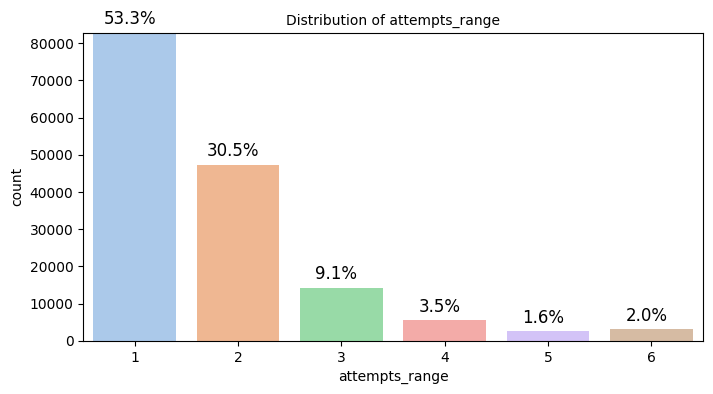

In [11]:
# plot distribution of has_uninstalled to check if there's class imbalance or not
plt.figure(figsize=(8, 4))
plt.title("Distribution of attempts_range", fontsize=10)
plot = sns.countplot(x='attempts_range', data=train, palette='pastel')
plt.ylim(0, train['attempts_range'].value_counts().max() + 1)  

def target(plot):
    total = len(train['attempts_range'])
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        plot.annotate(percentage, (x, y), size=12, ha='center', va='center', xytext=(0, 10), textcoords='offset points')

target(plot)
plt.show()

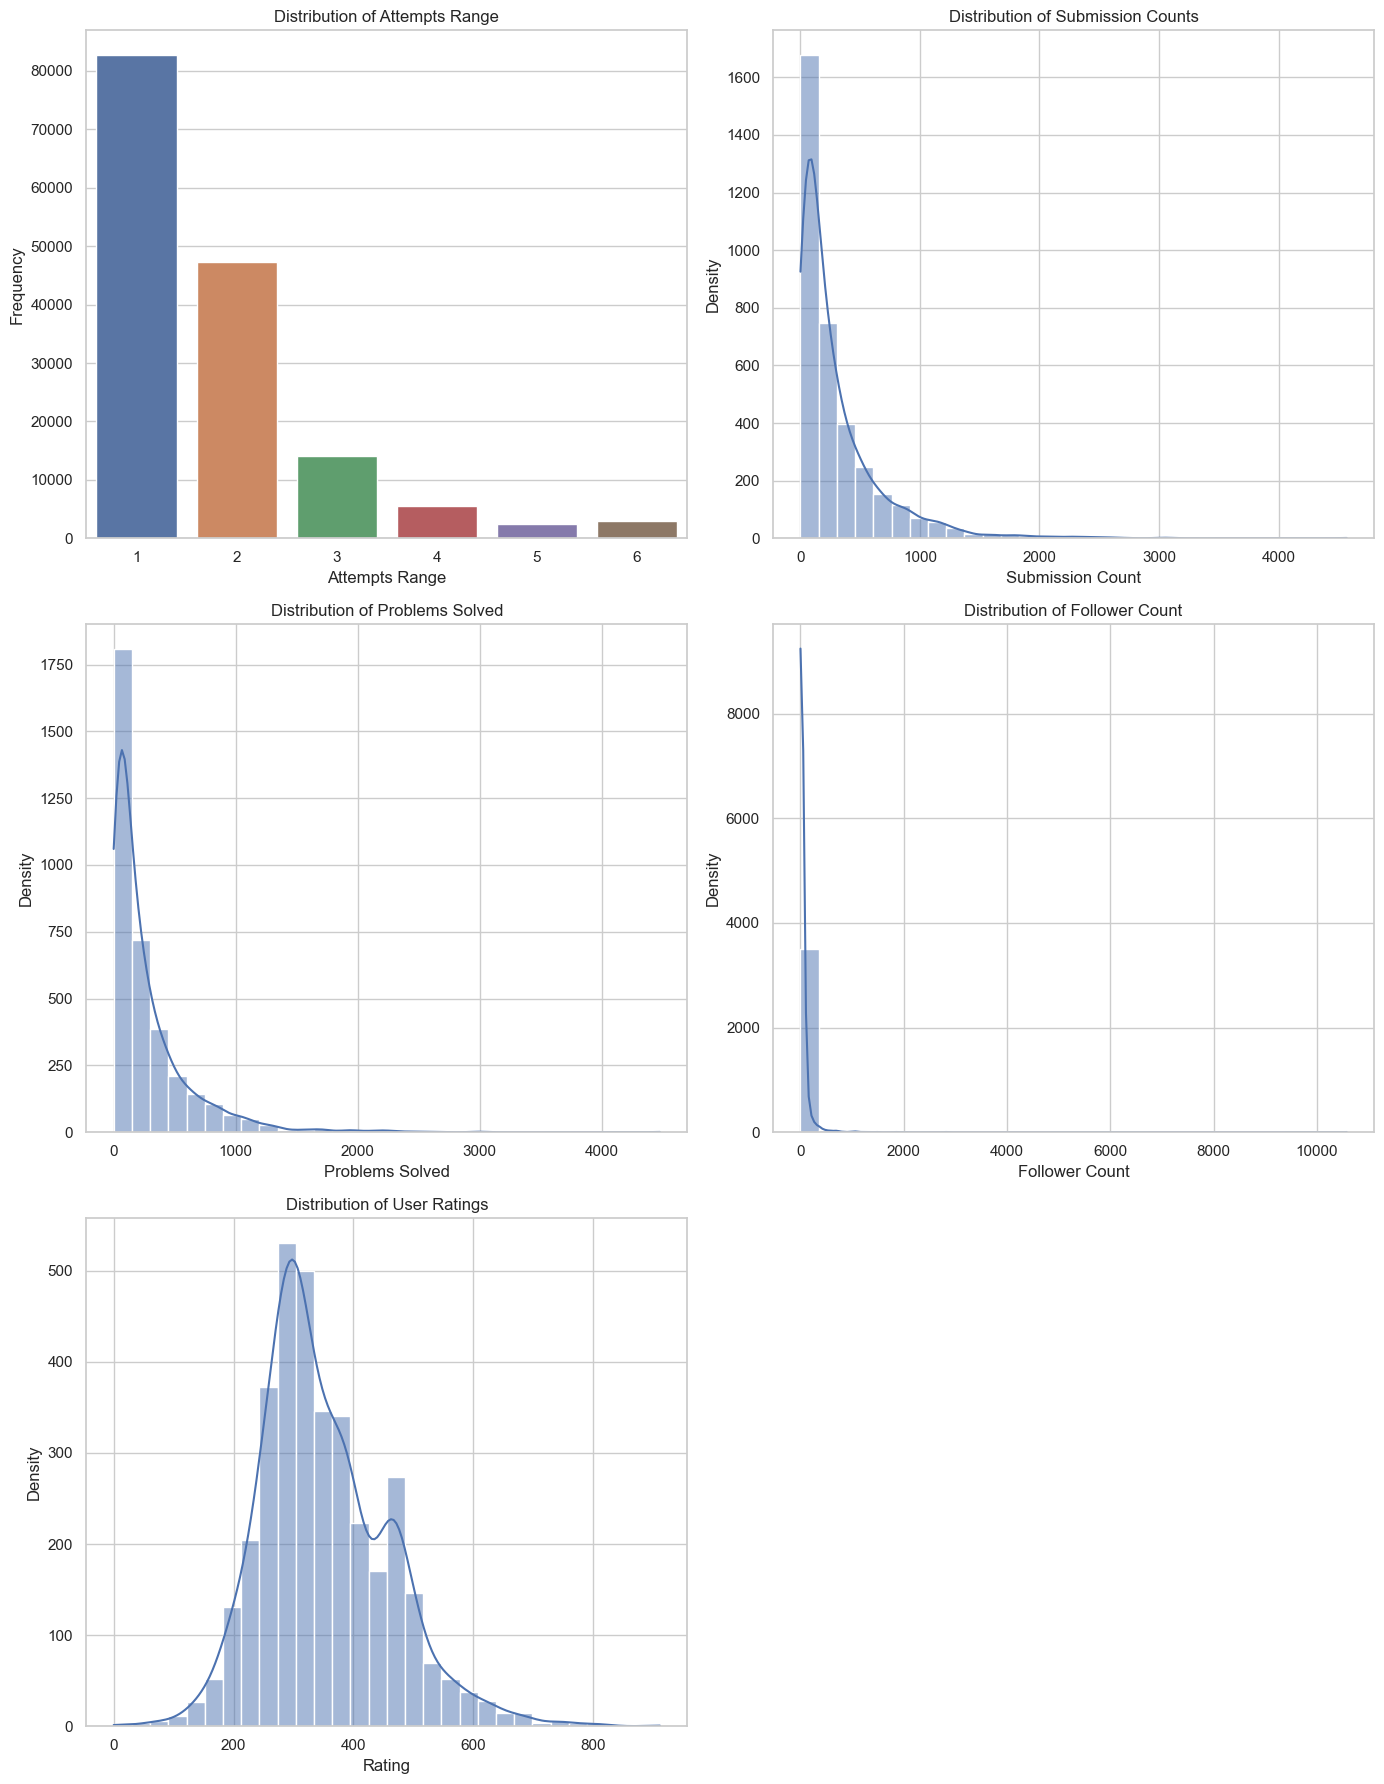

In [12]:
def plot_data_distributions(train_submissions, user_data):
    """
    Creates a series of plots to visualize the distributions of various data features.
    """
    # Set the aesthetic style of the plots
    sns.set(style="whitegrid")

    # Create a figure to hold the visualizations
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 18))

    # Plot distribution of attempts_range
    sns.countplot(x='attempts_range', data=train_submissions, ax=axes[0, 0])
    axes[0, 0].set_title('Distribution of Attempts Range')
    axes[0, 0].set_xlabel('Attempts Range')
    axes[0, 0].set_ylabel('Frequency')

    # Plot distribution of submission_count
    sns.histplot(user_data['submission_count'], bins=30, kde=True, ax=axes[0, 1])
    axes[0, 1].set_title('Distribution of Submission Counts')
    axes[0, 1].set_xlabel('Submission Count')
    axes[0, 1].set_ylabel('Density')

    # Plot distribution of problem_solved
    sns.histplot(user_data['problem_solved'], bins=30, kde=True, ax=axes[1, 0])
    axes[1, 0].set_title('Distribution of Problems Solved')
    axes[1, 0].set_xlabel('Problems Solved')
    axes[1, 0].set_ylabel('Density')

    # Plot distribution of follower_count
    sns.histplot(user_data['follower_count'], bins=30, kde=True, ax=axes[1, 1])
    axes[1, 1].set_title('Distribution of Follower Count')
    axes[1, 1].set_xlabel('Follower Count')
    axes[1, 1].set_ylabel('Density')

    # Plot distribution of user ratings
    sns.histplot(user_data['rating'], bins=30, kde=True, ax=axes[2, 0])
    axes[2, 0].set_title('Distribution of User Ratings')
    axes[2, 0].set_xlabel('Rating')
    axes[2, 0].set_ylabel('Density')

    # Remove empty subplot (if any)
    fig.delaxes(axes[2, 1])

    plt.tight_layout()
    plt.show()

plot_data_distributions(train_submissions, user_data)

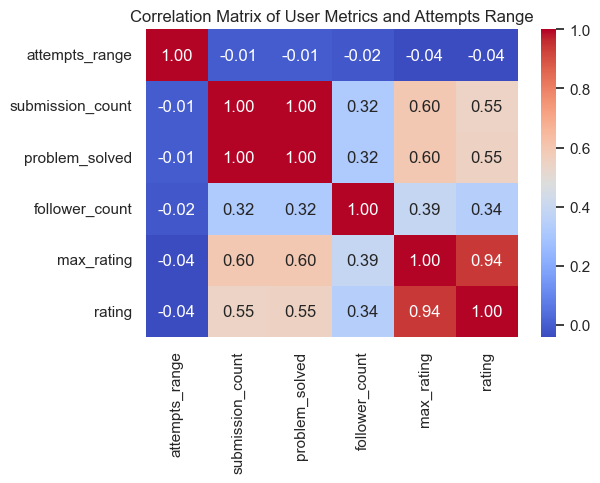

In [13]:
def plot_correlation_matrix(train_submissions, user_data):
    """
    Merges training submission data with user data and plots the correlation matrix
    for user-related features and attempts_range.
    """
    # Merging train_submissions with user_data
    train_user_merged = pd.merge(train_submissions, user_data, on='user_id', how='left')

    # Compute correlation matrix for user-related features and attempts_range
    user_correlation = train_user_merged[['attempts_range', 'submission_count', 'problem_solved', 'follower_count', 'max_rating', 'rating']].corr()

    # Visualizing the correlation matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(user_correlation, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix of User Metrics and Attempts Range')
    plt.show()

plot_correlation_matrix(train_submissions, user_data)


- Submission Count: Slightly negative correlation with attempts_range. This suggests that users who have more - submissions tend to require fewer attempts on average to solve a problem.
- Problem Solved: Similar to submission count, there is a slight negative correlation. Users who have solved more problems generally need fewer attempts to solve new problems.
- Follower Count: Very weak negative correlation. This might indicate that more popular users (or those with more followers) slightly tend to solve problems with fewer attempts, though the effect is minimal.
- Max Rating and Rating: Both show weak negative correlations with attempts_range. Higher-rated users, likely more skilled, also seem to solve problems with fewer attempts. These also show multicollinearity, so no need to use both in the model

The negative correlations, although weak, consistently suggest that more active and higher-performing users need fewer attempts to solve problems. These features might be useful predictors for our model, indicating that incorporating user activity and performance metrics could help in predicting the number of attempts required.

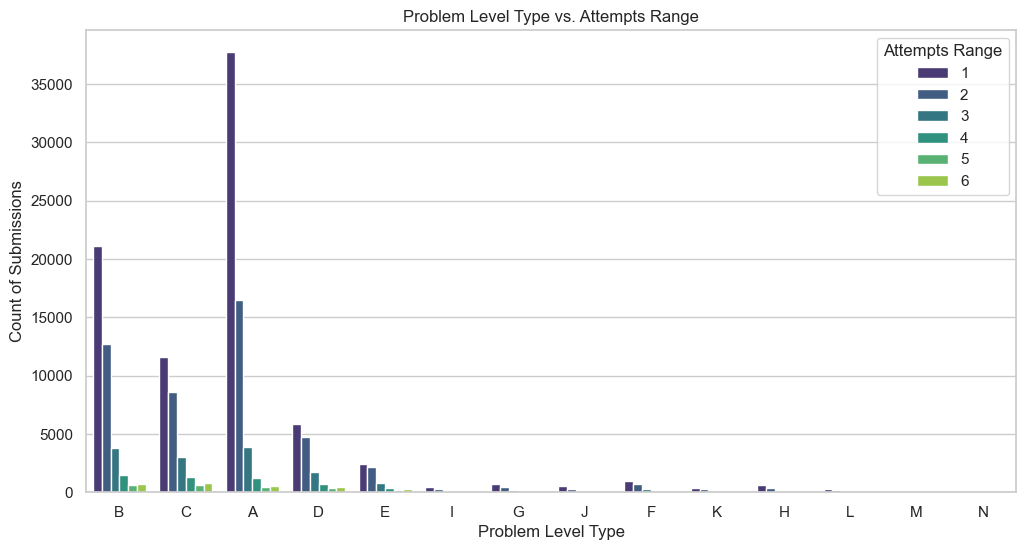

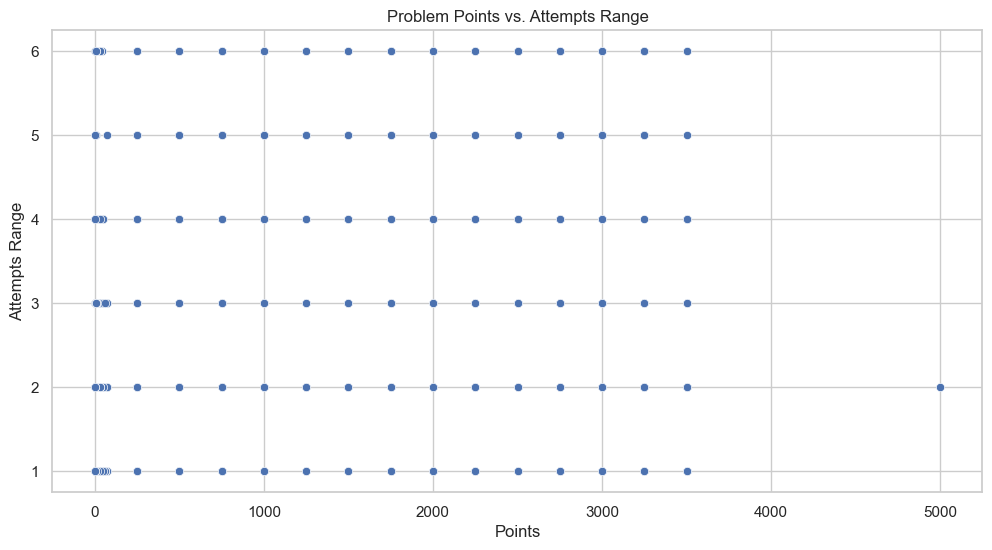

In [14]:
def visualize_problem_data(train_submissions, problem_data):
    """
    Merges training submissions data with problem data and creates visualizations to 
    analyze the relationship between problem characteristics and attempts range.4
    """
    # Merging train_submissions with problem_data
    train_problem_merged = pd.merge(train_submissions, problem_data, on='problem_id', how='left')

    # Visualizing the relationship between level_type and attempts_range
    plt.figure(figsize=(12, 6))
    sns.countplot(x='level_type', hue='attempts_range', data=train_problem_merged, palette='viridis')
    plt.title('Problem Level Type vs. Attempts Range')
    plt.xlabel('Problem Level Type')
    plt.ylabel('Count of Submissions')
    plt.legend(title='Attempts Range', loc='upper right')
    plt.show()

    # Visualizing the relationship between points and attempts_range using a scatter plot
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='points', y='attempts_range', data=train_problem_merged)
    plt.title('Problem Points vs. Attempts Range')
    plt.xlabel('Points')
    plt.ylabel('Attempts Range')
    plt.show()

visualize_problem_data(train_submissions, problem_data)


- Problem Level Type vs. Attempts Range:
The distribution across different problem levels shows that certain levels (like level H, which often represents higher complexity) have a wider spread in the number of attempts, indicating variability in difficulty or user skill.
Lower levels (like A and B) predominantly see problems solved in fewer attempts, suggesting these are easier.
- Problem Points vs. Attempts Range:
The scatter plot shows a relatively dispersed relationship between the points awarded for a problem and the attempts range. This indicates that while points might signify problem difficulty, there's no strong linear relationship with the number of attempts. This could be due to varying user skill levels handling the same problem differently.

In [26]:
def drop_country(df,column):
    """
    drops country column from train and test
    """
    df = df.drop([column],axis=1)
    
    return df

train = drop_country (train,'country')
test = drop_country(test,'country')

In [27]:
def encode_features(train, test):
    """
    Applies label encoding to 'country', 'level_type', and 'tags' and one-hot encoding to 'rank'.

    """
    # Initialize LabelEncoder
    label_encoder = LabelEncoder()
    
    # Columns to be label encoded
    label_features = ['level_type', 'tags']
    
    # Apply label encoding to each label feature
    for feature in label_features:
        # Combine the data from train and test to fit the encoder
        combined = pd.concat([train[feature], test[feature]], axis=0).astype(str)
        label_encoder.fit(combined)
        
        # Transform each dataset
        train[feature] = label_encoder.transform(train[feature].astype(str))
        test[feature] = label_encoder.transform(test[feature].astype(str))
    
    # Apply one-hot encoding to 'rank'
    train = pd.get_dummies(train, columns=['rank'], drop_first=True)
    test = pd.get_dummies(test, columns=['rank'], drop_first=True)
    
    return train, test

train, test = encode_features(train, test)

### Modelling

In [17]:
def calculate_predictive_power(df, target):
    """
    Calculates the predictive power score (PPS) for variables in a dataframe against a target variable.
    
    """
    # Target variable should be of type string for PPS calculation
    df = df.drop(['problem_id','user_id'],axis=1)
    df[target] = df[target].astype(str)
    predictors_df = pps.predictors(df, target)
    sorted_predictors = predictors_df.sort_values(by="ppscore", ascending=False)
    
    return sorted_predictors

predictors_df = calculate_predictive_power(train, "attempts_range")
predictors_df

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,problem_solved,attempts_range,0.059792,classification,True,weighted F1,0.3908,0.427225,DecisionTreeClassifier()
1,submission_count,attempts_range,0.058814,classification,True,weighted F1,0.3908,0.426629,DecisionTreeClassifier()
2,max_rating,attempts_range,0.057063,classification,True,weighted F1,0.3908,0.425563,DecisionTreeClassifier()
3,tags,attempts_range,0.051406,classification,True,weighted F1,0.3908,0.422117,DecisionTreeClassifier()
4,last_online_time_seconds,attempts_range,0.044846,classification,True,weighted F1,0.3908,0.418120,DecisionTreeClassifier()
5,success_rate,attempts_range,0.044815,classification,True,weighted F1,0.3908,0.418101,DecisionTreeClassifier()
6,rating,attempts_range,0.034943,classification,True,weighted F1,0.3908,0.412087,DecisionTreeClassifier()
7,registration_time_seconds,attempts_range,0.031462,classification,True,weighted F1,0.3908,0.409967,DecisionTreeClassifier()
8,points,attempts_range,0.029243,classification,True,weighted F1,0.3908,0.408615,DecisionTreeClassifier()
9,follower_count,attempts_range,0.010042,classification,True,weighted F1,0.3908,0.396918,DecisionTreeClassifier()


#### Predictive Power Analysis
Looking at another alternative of correlation analysis using predictive power score: The predictive power score is an finds more patterns in the data than correlation does

The numner of problems a user has solved, thier rating and number of submissions they made seem to be strong predictors of the how many attempts they will need to solve a problem.

In [28]:
def set_features_and_target(df):
    '''
    Returns two data frames with features and target variables.
            Parameters:
                    df (str): Pandas dataframe
    '''
    #X = df[['problem_solved','submission_count','max_rating','tags','last_online_time_seconds','success_rate']]
    X = df.drop(['user_id','problem_id','attempts_range'],axis=1)
    y = df['attempts_range']
    
    return X,y
                 
X,y = set_features_and_target(train)
print(X.shape, y.shape)

(155295, 15) (155295,)


In [10]:
#test = test[['ID','user_id','problem_id','problem_solved','submission_count','max_rating','tags','last_online_time_seconds','success_rate']]

In [29]:
def train_test_split_df(X,y):
    '''
    Creates train and test split.

    '''
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split_df(X,y)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(108706, 15) (108706,)
(46589, 15) (46589,)


In [50]:
def model_application(X_train,y_train,optimiser):
    '''
    Model application. If optimiser is true , a randomised search is applied to optimise the model. 
    If optimiser is false base model is used
            Parameters:
                    X_train : Pandas dataframe of feature set training variables
                    y_train : Pandas dataframe of predictor variable for training set.
                    optimiser : Boolean to indicate optimisation required. 
            Returns:
                    Random Forest model.
    '''
    if optimiser == True:
                # Build the model with K-fold validation and GridSearch to find the best parameters

                # Defining all the parameters
                params = {
                        'max_features': ['sqrt', 'log2'],  
                        'min_samples_split': [2, 10],     
                        'min_samples_leaf': [1, 10],       
                        'criterion': ['gini']              
                        }

                cv = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=15)
                # Building model
                rf = RandomForestClassifier()
                grid = RandomizedSearchCV(rf, param_distributions=params, n_iter=10, scoring='accuracy', n_jobs=-1, cv=cv, verbose=1)
                grid.fit(X_train, y_train)
                dtc_grid_val_score = grid.best_score_
                print('Best Score:', dtc_grid_val_score)
                print('Best Params:', grid.best_params_)
                print('Best Estimator:', grid.best_estimator_)
                rf_clf = grid.best_estimator_
    else:
                rf_clf = RandomForestClassifier(n_estimators=20,
                                                max_depth=16,
                                                criterion='gini',
                                                class_weight='balanced',
                                                min_samples_split=10,
                                                max_leaf_nodes=20,
                                                max_features=0.5,
                                                bootstrap=True)
                rf_clf.fit(X_train, y_train)

    return rf_clf

optimiser = True
rf_clf = model_application(X_train,y_train,optimiser)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
Best Score: 0.5334539433337422
Best Params: {'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'criterion': 'gini'}
Best Estimator: RandomForestClassifier(min_samples_leaf=10, min_samples_split=10)


In [45]:
def model_predict(X_test):
    '''
    Create y_pred , model prediction based on test set features.
            Parameters:
                    X_test (str): Pandas dataframe
            Returns:
                    y_pred
    '''
    y_pred = rf_clf.predict(X_test)
    
    return y_pred

y_pred = model_predict(X_test)
print('Training Accuracy Score(%):',rf_clf.score(X_train,y_train)*100)
print('Test Accuracy Score(%):',rf_clf.score(X_test,y_test)*100)

Training Accuracy Score(%): 55.291336264787596
Test Accuracy Score(%): 53.306574513297136


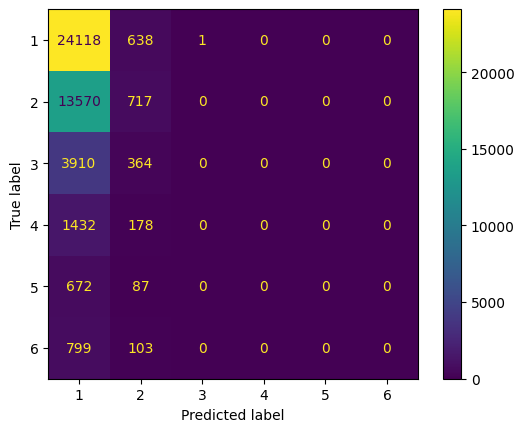

array([[24118,   638,     1,     0,     0,     0],
       [13570,   717,     0,     0,     0,     0],
       [ 3910,   364,     0,     0,     0,     0],
       [ 1432,   178,     0,     0,     0,     0],
       [  672,    87,     0,     0,     0,     0],
       [  799,   103,     0,     0,     0,     0]], dtype=int64)

In [52]:
def generate_confusion_matrix(y_test, y_pred):
    '''
    Generates confusion matrix.
            Parameters:
                    y_test (array): numpy array of actual values
                    y_pred (array): numpy array of predicted values
            Returns:
                    Y_pred
    '''
    
    cm = confusion_matrix(y_test, y_pred, labels=rf_clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)
    disp.plot()
    plt.grid(False) 
    plt.show()
    
    return cm

generate_confusion_matrix(y_test, y_pred)

In [47]:
def generate_perfomance_metrics(y_test,y_pred):
    '''
    Generates perfomance metrics precision, recall, f1 score, accuracy
            Parameters:
                    y_test (array): numpy array of actual values
                    y_pred (array): numpy array of predicted values
            Returns:
                    y_pred
    '''
    rf_model_score = accuracy_score(y_test, y_pred)
    print('Model Accuracy:', rf_model_score)
    return print('Classification Report:\n', classification_report(y_test, y_pred))

generate_perfomance_metrics(y_test,y_pred)

Model Accuracy: 0.5330657451329713
Classification Report:
               precision    recall  f1-score   support

           1       0.54      0.97      0.70     24757
           2       0.34      0.05      0.09     14287
           3       0.00      0.00      0.00      4274
           4       0.00      0.00      0.00      1610
           5       0.00      0.00      0.00       759
           6       0.00      0.00      0.00       902

    accuracy                           0.53     46589
   macro avg       0.15      0.17      0.13     46589
weighted avg       0.39      0.53      0.40     46589



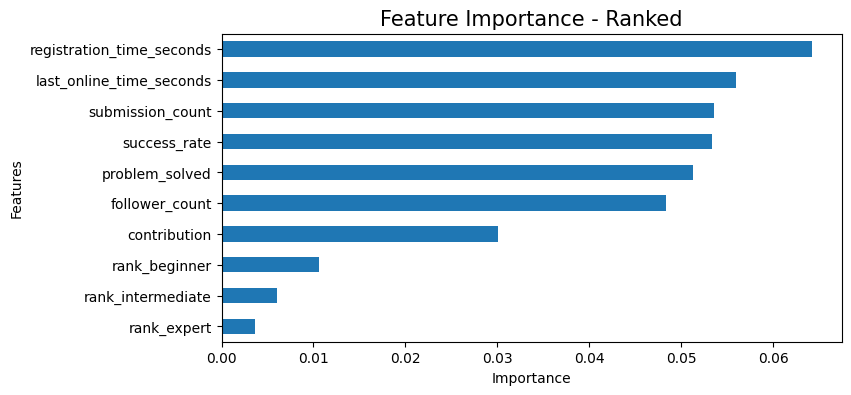

In [48]:
def plot_feature_importance(model, feature_names, n=10):
    
    '''
    Produces a plot displaying features that are most important predictors of the target feature.
            Parameters:
                    random forest model
                    feature names
    '''
    
    plt.figure(figsize=(8, 4))

    feat_importances = pd.Series(model.feature_importances_, index=feature_names)
    feat_importances.nsmallest(n).plot(kind='barh')
    importances = model.feature_importances_
    indices = np.argsort(importances)

    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title("Feature Importance - Ranked", fontsize=15)
    plt.show()

plot_feature_importance(rf_clf, X_train.columns)

In [49]:
# apply trained model to test
#X_test_features = test[['problem_solved','submission_count','max_rating','tags','last_online_time_seconds','success_rate']]
X_test_features = test.drop(['ID','problem_id','user_id'],axis=1)
predicted_attempts = rf_clf.predict(X_test_features)
predictions_df = test[['ID']].copy()  
predictions_df['attempts_range'] = predicted_attempts
# save the test predictions as csv file
predictions_df.to_csv('C:/Users/leemn/Downloads/analytics_vidhya/predicted_attempts_.csv',index=False)
predictions_df.head()

,ID,attempts_range
0,user_856_prob_5822,1
1,user_2642_prob_2334,1
2,user_2557_prob_2920,1
3,user_1572_prob_4598,1
4,user_295_prob_6139,1
